# 2. Hough Transform

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
# Load image
image_runway = cv2.imread('runway.jpeg', cv2.IMREAD_GRAYSCALE)  # Make sure to use the correct path
image_SpaceXmap = cv2.imread('SpaceXmap.jpg',cv2.IMREAD_GRAYSCALE)  # Make sure to use the correct path

### Canny Edge Detection

In [ ]:
def edge_detection(image, threshold1=50, threshold2=100):
    # Smooth the image using a Gaussian filter
    sigma = 1.4
    length = 5
    # Compute Gaussian filter
    k = length // 2  # Half size of the filter
    gaussian = np.zeros([length, length])  # Initialize a zero matrix for the Gaussian filter
    
    # Fill in the Gaussian filter with values based on the equation
    for i in range(length):
        for j in range(length):
            gaussian[i, j] = np.exp(-((i-k) ** 2 + (j-k) ** 2) / (2 * sigma ** 2))
    
    # Normalize the filter to ensure the sum of weights is 1
    gaussian /= 2 * np.pi * sigma ** 2
    gaussian = gaussian / np.sum(gaussian)  # Normalize by the sum of all values in the filter

    # Get image dimensions
    W, H = image.shape
    # Initialize a new image to store the smoothed result
    smoothed = np.zeros([W - k * 2, H - k * 2])

    # Apply the Gaussian filter using a sliding window approach
    for i in range(W - 2 * k):
        for j in range(H - 2 * k):
            smoothed[i, j] = np.sum(image[i:i+length, j:j+length] * gaussian)

    # Convert the result to an unsigned 8-bit integer type
    smoothed = np.uint8(smoothed)
    
    # Sobel filters for calculating gradients in x and y directions
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    W, H = smoothed.shape
    # Initialize matrices to store gradients and direction values
    gradients = np.zeros([W - 2, H - 2])
    direction = np.zeros([W - 2, H - 2])

    # Apply the Sobel operator to calculate the gradient magnitude and direction
    for i in range(W - 2):
        for j in range(H - 2):
            dx = np.sum(smoothed[i:i+3, j:j+3] * Gx)  # Calculate gradient in x-direction
            dy = np.sum(smoothed[i:i+3, j:j+3] * Gy)  # Calculate gradient in y-direction
            gradients[i, j] = np.sqrt(dx ** 2 + dy ** 2)  # Compute gradient magnitude
            # Compute gradient direction
            if dx == 0:
                direction[i, j] = np.pi / 2
            else:
                direction[i, j] = np.arctan(dy / dx)

    # Convert gradient magnitudes to uint8 type
    gradients = np.uint8(gradients)
    W, H = gradients.shape
    nms = np.copy(gradients[1:-1, 1:-1])  # Create a copy of the gradients for Non-Maximum Suppression

    # Perform NMS for each pixel in the image
    for i in range(1, W - 1):
        for j in range(1, H - 1):
            theta = direction[i, j]
            weight = np.tan(theta)  # Calculate weight based on the gradient direction
            if theta > np.pi / 4:
                d1 = [0, 1]
                d2 = [1, 1]
                weight = 1 / weight  # Adjust for different edge directions
            elif theta >= 0:
                d1 = [1, 0]
                d2 = [1, 1]
            elif theta >= - np.pi / 4:
                d1 = [1, 0]
                d2 = [1, -1]
                weight *= -1
            else:
                d1 = [0, -1]
                d2 = [1, -1]
                weight = -1 / weight

            # Calculate the gradient values at the neighboring positions
            g1 = gradients[i + d1[0], j + d1[1]]
            g2 = gradients[i + d2[0], j + d2[1]]
            g3 = gradients[i - d1[0], j - d1[1]]
            g4 = gradients[i - d2[0], j - d2[1]]

            # Combine gradients based on direction and weights
            grade_count1 = g1 * weight + g2 * (1 - weight)
            grade_count2 = g3 * weight + g4 * (1 - weight)

            # Suppress non-maximal values
            if grade_count1 > gradients[i, j] or grade_count2 > gradients[i, j]:
                nms[i - 1, j - 1] = 0
    # Perform double thresholding
        # Initialize variables for visited pixels and output image
    visited = np.zeros_like(nms)
    output_image = nms.copy()
    W, H = output_image.shape

    def dfs(i, j):
        # Depth-first search to connect pixels above threshold2
        if i >= W or i < 0 or j >= H or j < 0 or visited[i, j] == 1:
            return
        visited[i, j] = 1
        if output_image[i, j] > threshold1:
            output_image[i, j] = 255  # Mark as strong edge
            # Recursively visit neighboring pixels
            dfs(i-1, j-1)
            dfs(i-1, j)
            dfs(i-1, j+1)
            dfs(i, j-1)
            dfs(i, j+1)
            dfs(i+1, j-1)
            dfs(i+1, j)
            dfs(i+1, j+1)
        else:
            output_image[i, j] = 0  # Mark as weak edge

    # Perform double thresholding to classify edges
    for w in range(W):
        for h in range(H):
            if visited[w, h] == 1:
                continue
            if output_image[w, h] >= threshold2:
                dfs(w, h)  # Strong edge found, trace it
            elif output_image[w, h] <= threshold1:
                output_image[w, h] = 0  # Weak or no edge
                visited[w, h] = 1

    # Remove all unvisited weak edges
    for w in range(W):
        for h in range(H):
            if visited[w, h] == 0:
                output_image[w, h] = 0

    return output_image

### Edge Detection in Runway Image 

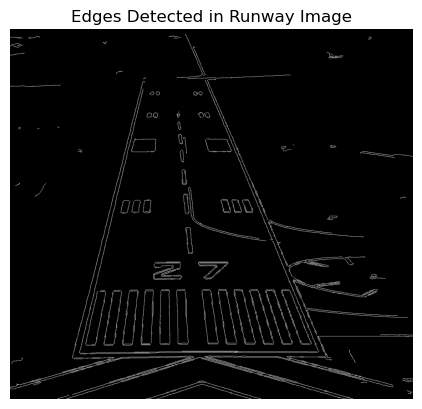

In [4]:
# Apply Canny edge detection
# edges_runway = cv2.Canny(image_runway, 50, 280)  # Tune the thresholds for best results
# smoothed_image = smooth(image_runway)
# gradients, direction = get_gradient_and_direction(smoothed_image)
# nms = NMS(gradients, direction)
# edges_runway = double_threshold(nms, 50, 180)
edges_runway = edge_detection(image_runway, 50, 180)
plt.imshow(edges_runway, cmap='gray')
plt.title("Edges Detected in Runway Image")
plt.axis('off')
plt.show()

### Hough transform for line detection (runway)

In [5]:
def custom_hough_lines(edges, rho_res=1, theta_res=np.pi / 180, threshold=150):
    # Get the shape of the edge image
    height, width = edges.shape
    
    # Define the range of rho and theta in polar coordinates
    max_rho = int(np.sqrt(height ** 2 + width ** 2))
    rhos = np.arange(-max_rho, max_rho + 1, rho_res)
    thetas = np.arange(0, np.pi, theta_res)
    
    # Initialize the accumulator array
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=int)
    
    # Find the coordinates of non-zero pixels in the edge image (edge points)
    edge_points = np.argwhere(edges)
    
    # Accumulation process: voting for each edge point
    for y, x in edge_points:
        for theta_idx, theta in enumerate(thetas):
            # Calculate the value of rho
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_idx = np.where(rhos == rho)[0][0]  # Find the index corresponding to rho
            accumulator[rho_idx, theta_idx] += 1   # Cast a vote
            
    # Find (rho, theta) pairs that meet the threshold
    lines = []
    for rho_idx, theta_idx in np.argwhere(accumulator >= threshold):
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        lines.append((rho, theta))
    
    return lines

### overlap in the image

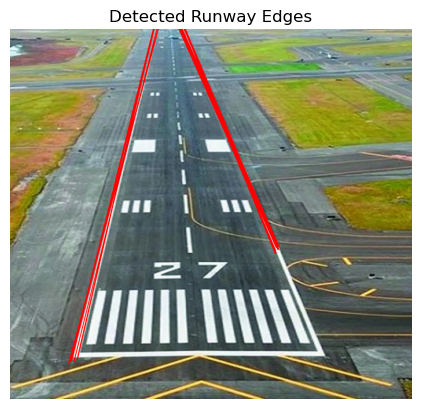

In [6]:
# Using Hough Transform from OpenCV
lines = custom_hough_lines(edges_runway, threshold=170)

# Draw the detected lines
output_image = cv2.imread('runway.jpeg')
for rho, theta in lines:
    # filter the lines based on the angle
    if theta < np.pi / 6  or theta > np.pi * 5 / 6:
        x1 = int(rho * np.cos(theta) - 1000 * np.sin(theta))
        y1 = int(rho * np.sin(theta) + 1000 * np.cos(theta))
        x2 = int(rho * np.cos(theta) + 1000 * np.sin(theta))
        y2 = int(rho * np.sin(theta) - 1000 * np.cos(theta))
    # draw the lines on the image
    cv2.line(output_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.imshow(output_image)
plt.title("Detected Runway Edges")
plt.axis('off')
plt.show()

### Edge Detection in Space X Image 

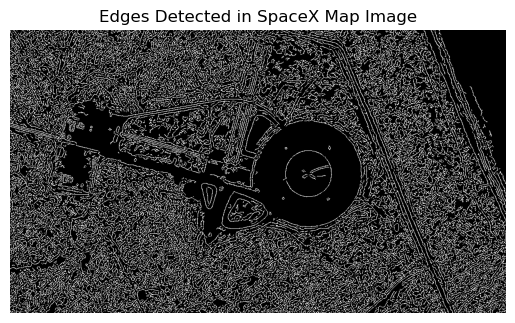

In [8]:
edges_spaceXmap = edge_detection(image_SpaceXmap, 10, 30)
plt.imshow(edges_spaceXmap, cmap='gray')
plt.title("Edges Detected in SpaceX Map Image")
plt.axis('off')
plt.show()

### Hough transform for circle detection (Space X)

In [ ]:
def houghGradint(edge, dp, minDist, param1, param2, minRadius, maxRadius):
    vacuum_thresh = param2  # Accumulator threshold for the center
    sobel_x = cv2.Sobel(edge, cv2.CV_64F, dx=1, dy=0, ksize=3)  # Gradient in the x direction
    sobel_y = cv2.Sobel(edge, cv2.CV_64F, dx=0, dy=1, ksize=3)  # Gradient in the y direction
    rows = edge.shape[0]
    cols = edge.shape[1]
    accumulator = np.zeros((rows, cols))  # Create an accumulator for the circle centers
    none_zero = np.zeros((rows, cols))
    gaussian_filter = 1.0 / 20 * np.array([[1, 2, 1], [2, 8, 2], [1, 2, 1]])  # Gaussian filter kernel
    sobel_x_pad = np.pad(sobel_x, ((1, 1), (1, 1)), 'constant')
    sobel_y_pad = np.pad(sobel_y, ((1, 1), (1, 1)), 'constant')
    for i in range(rows):
        for j in range(cols):
            if not edge[i][j] == 0:  # Process non-zero points
                dx_fields = sobel_x_pad[i:i + 3, j:j + 3]
                dy_fields = sobel_y_pad[i:i + 3, j:j + 3]
                dx = (dx_fields * gaussian_filter).sum()
                dy = (dy_fields * gaussian_filter).sum()
                if dx != 0 and dy != 0:  # Skip if derivative values are zero
                    none_zero[(i, j)] = 1
                    k = dy / (dx + 0.00000001)
                    if abs(k) < 0.05 or abs(k) > 50:  # Filter out certain slopes
                        continue
                    b = j - k * i
                    for t in range(rows):  # Increase x by one pixel at a time, calculate y
                        y = int(k * t + b)
                        if 0 < y < cols:  # Filter y, it should not exceed image size
                            accumulator[(t, y)] += 1
    points = [[], []]
    for i in range(rows):
        for j in range(cols):
            a = accumulator[(i, j)]
            if a > vacuum_thresh:
                points[0].append(i)
                points[1].append(j)
    sort_centers = []  # Process coordinates and add accumulator values for sorting
    for k in range(len(points[0])):
        sort_centers.append([])
        sort_centers[-1].append(points[0][k])
        sort_centers[-1].append(points[1][k])
        sort_centers[-1].append(accumulator[(points[0][k], points[1][k])])
    sort_centers.sort(key=lambda x: x[2], reverse=True)
    possible_centers = sort_centers[:(len(sort_centers))]  # Select points with higher voting values as candidate circle centers
    radii = maxRadius - minRadius  # Define radius and create an accumulator for it
    radius_accumulator = np.zeros(radii)
    for i in range(rows):
        for j in range(cols):
            if not edge[i, j] == 0:
                for t in range(len(possible_centers)):
                    x0 = possible_centers[t][0]
                    y0 = possible_centers[t][1]
                    r = int(sqrt((x0 - i) ** 2 + (y0 - j) ** 2))  # Calculate the distance from each candidate circle center to non-zero points
                    if minRadius < r < maxRadius:
                        radius_accumulator[r - minRadius] += 1
    res = radius_accumulator.argsort()[::-1]  # Sort the radius in descending order
    true_radius = res[0] + minRadius
    for i in range(rows):
        for j in range(cols):
            if not edge[i, j] == 0:  # For each edge point, calculate the distance to candidate circle centers
                for k in range(len(possible_centers) - 1, -1, -1):  # Reverse iteration for deletion
                    a = possible_centers[k][0]
                    b = possible_centers[k][1]
                    dist = int(sqrt((a - i) ** 2 + (b - j) ** 2))
                    delta = 5  # Allowable difference between center and edge points
                    if abs(dist - true_radius) > delta:  # Discard if distance exceeds the set threshold
                        possible_centers.remove(possible_centers[k])
    circles = [[], [], []]
    length = len(possible_centers)
    a_mean = sum([possible_centers[i][0] for i in range(length)]) / length
    b_mean = sum([possible_centers[i][1] for i in range(length)]) / length
    circles[0].append(round(a_mean))
    circles[1].append(round(b_mean))
    circles[2].append(true_radius)
    return circles

### Overlap in the image

In [11]:
circles = houghGradint(edges_spaceXmap, 1, 2, 50, 40, 30, 120)
circles = np.uint16(np.around(circles))
output_image = cv2.imread('SpaceXmap.jpg')
if circles is not None:
    circles = np.uint16(np.around(circles))
    for x, y, radius in circles[0, :]:
        # filter out the circle that is not in the center
        if abs(x - 620) < 20 and abs(y - 320) < 20:
            cv2.circle(output_image, (x, y), radius, (0,0, 255), 4)
output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.imshow(output_image)
plt.title("Hough Circle Detection")
plt.axis('off')
plt.show()

[[0, 1, 44.0], [0, 2, 48.0], [0, 3, 43.0], [0, 4, 60.0], [0, 5, 49.0], [0, 6, 48.0], [0, 7, 47.0], [0, 9, 54.0], [0, 10, 58.0], [0, 11, 45.0]]


KeyboardInterrupt: 